<a href="https://colab.research.google.com/github/XuRui314/MathematicalModeling/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# preparation
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


![](https://img-blog.csdnimg.cn/d55c9ad9f9ae4c5fbe1954267e286afd.png?x-oss-process=image/watermark,type_ZHJvaWRzYW5zZmFsbGJhY2s,shadow_50,text_Q1NETiBA6IOW5ZOl55yf5LiN6ZSZ,size_20,color_FFFFFF,t_70,g_se,x_16)

## 1.项目背景

随着大数据时代的到来，具备大数据思想至关重要，人工智能技术在各行各业的应用已是随处可见。金融机构因车辆贷款违约而遭受重大损失。这导致汽车贷款承销收紧，汽车贷款拒收率上升。这些机构也提出了建立更好的信用风险评分模式的必要性。这值得进行一项研究，以估计车辆贷款违约的决定因素。金融机构想要准确预测贷款人/借款人在到期日第一个 EMI（等同于每月分期付款）中拖欠车辆贷款的概率。

数据集中提供了有关贷款和贷款人的信息：

- 贷款人信息（人口数据，如年龄、身份证明等）

- 贷款信息（付款详情、贷款与价值比率等）

- 统计局数据与历史（局分数、活跃账户数、其他贷款状况、信用记录等）

这样做将确保能够还款的客户不会被拒绝，并可以确定重要的决定因素，这些决定因素可以进一步用于将违约率降至最低。 

说人话就是根据各种特征，来建立一个模型，用于预测分类该客户会不会贷款违约。

In [2]:
import os
os.chdir("/content/drive/MyDrive/dataset/MathModel/XGBoost")
!ls

data.xlsx


In [33]:

# 导入各种工具
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
# 集成方法
from xgboost import XGBClassifier
# 评估指标
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, \
    classification_report, confusion_matrix

# warnings包
import warnings

warnings.filterwarnings("ignore")

In [4]:
# 40MB读要花2min30s :)
import pandas as pd
df = pd.read_excel('data.xlsx')

In [5]:
df[0:5]

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


## 3.数据预处理

真实数据中可能包含了大量的缺失值和噪音数据或人工录入错误导致有异常点存在，非常不利于算法模型的训练。数据清洗的结果是对各种脏数据进行对应方式的处理，得到标准的、干净的、连续的数据，提供给数据统计、数据挖掘等使用。数据预处理通常包含数据清洗、归约、聚合、转换、抽样等方式，数据预处理质量决定了后续数据分析挖掘及建模工作的精度和泛化价值。以下简要介绍数据预处理工作中主要的预处理方法：


### 去除挖掘无关重要的特征

一些ID标识类的数据参与机器建模没有意义，所以在此进行去掉，主要包括：



In [6]:
# 去除挖掘无关重要的特征
df = df.drop(
    ['UniqueID', 'branch_id', 'supplier_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],
    axis=1)
df[0:5]

,disbursed_amount,asset_cost,ltv,manufacturer_id,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,45,01-01-84,Salaried,2003/8/18,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,47145,65550,73.23,45,31-07-85,Self employed,2026/9/18,1,0,0,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,53278,61360,89.63,45,24-08-85,Self employed,2001/8/18,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,57513,66113,88.48,45,30-12-93,Self employed,2026/10/18,1,0,0,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,52378,60300,88.39,45,09-12-77,Self employed,2026/9/18,1,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


### 特征文本数据转换

1.数据项：PERFORM_CNS.SCORE.DESCRIPTION

PERFORM_CNS.SCORE.DESCRIPTION此数据项为文本类型的分数级别描述，需要转换成数值型的信用风险等级：



In [7]:
import numpy as np
# 特征文本数据转换
def credit_risk(df):
    d1 = []
    d2 = []
    for i in df:
        p = i.split("-") 
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d2


sub_risk = {'unknown': -1, 'A': 13, 'B': 12, 'C': 11, 'D': 10, 'E': 9, 'F': 8, 'G': 7, 'H': 6, 'I': 5, 'J': 4, 'K': 3,
            'L': 2, 'M': 1}
employment_map = {'Self employed': 0, 'Salaried': 1, np.nan: 2}

df.loc[:, 'credit_risk_grade'] = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:, 'Credit Risk'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

print(df['Credit Risk'].head())

df.loc[:, 'Employment Type'] = df['Employment.Type'].apply(lambda x: employment_map[x])

print(df['Employment Type'].head())

0   -1
1    5
2   -1
3    2
4   -1
Name: Credit Risk, dtype: int64
0    1
1    0
2    0
3    0
4    0
Name: Employment Type, dtype: int64


In [8]:
df = df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade', 'Employment.Type'], axis=1)

In [9]:
# 客户年龄计算
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >= 0 and yr <= 19:
        return yr + 2000
    else:
        return yr + 1900


def age1(dur):
    yr = int(dur.split('/')[0])

    return yr


df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age1)
df['Age'] = df['DisbursalDate'] - df['Date.of.Birth']
df = df.drop(['DisbursalDate', 'Date.of.Birth'], axis=1)

print(df['Age'].head())

0    19
1    41
2    16
3    33
4    49
Name: Age, dtype: int64


### 文本数据处理
AVERAGE.ACCT.AGE 平均贷款年租期

CREDIT.HISTORY.LENGTH 自第一次贷款以来的时间

本次主要是针对这两个数据项的处理，原始数据如下：


In [15]:
df[['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH']][0:5]

,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH
0,0yrs 0mon,0yrs 0mon
1,1yrs 11mon,1yrs 11mon
2,0yrs 0mon,0yrs 0mon
3,0yrs 8mon,1yrs 3mon
4,0yrs 0mon,0yrs 0mon


In [16]:
# 文本数据处理
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs', ''))
    mon = int(dur.split(' ')[1].replace('mon', ''))
    return yrs * 12 + mon


df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)

print(df['AVERAGE.ACCT.AGE'].head())
print(df['CREDIT.HISTORY.LENGTH'].head())

0     0
1    23
2     0
3     8
4     0
Name: AVERAGE.ACCT.AGE, dtype: int64
0     0
1    23
2     0
3    15
4     0
Name: CREDIT.HISTORY.LENGTH, dtype: int64


In [17]:
df[0:5]

,disbursed_amount,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Credit Risk,Employment Type,Age
0,50578,58400,89.55,45,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,1,19
1,47145,65550,73.23,45,1,0,0,0,0,598,...,0,0,1,23,23,0,1,5,0,41
2,53278,61360,89.63,45,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,0,16
3,57513,66113,88.48,45,1,0,0,0,0,305,...,0,0,0,8,15,1,1,2,0,33
4,52378,60300,88.39,45,1,0,0,0,0,0,...,0,0,0,0,0,1,1,-1,0,49


## 4.探索性数据分析
### 数值型特征变量T检验与特征选择




相关资料：
- https://zhuanlan.zhihu.com/p/107738381
- https://www.cnblogs.com/massquantity/p/10486904.html
- https://www.zhihu.com/question/309884517

![](https://pic2.zhimg.com/v2-55498b3f0a549a74ec472c0a07eb10f1_r.jpg)

这里就是预测变量为连续，反应变量为离散，因此选用两样本T检验和ANOVA。

In [18]:
numerical = ['disbursed_amount', 'asset_cost', 'PRI.NO.OF.ACCTS',
             'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
             'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
             'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
             'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
             'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
             'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'Age', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
             'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
categorical = ['manufacturer_id', 'Aadhar_flag', 'PAN_flag',
               'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
               'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
               'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES', 'Credit Risk', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH',
               'Employment Type']

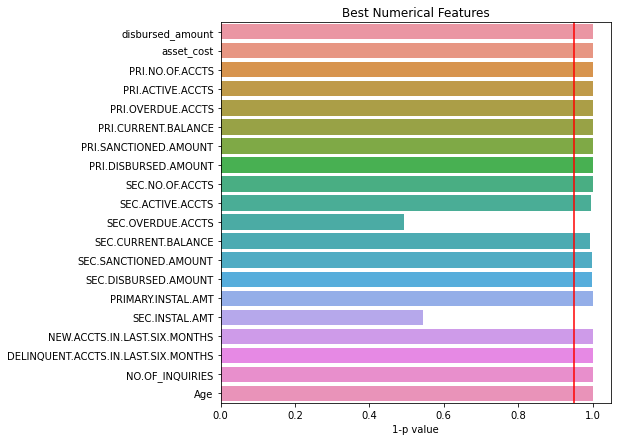

In [19]:
# 数值型特征变量T检验与特征选择
p = []
from scipy.stats import ttest_ind
# 按照loan default也就是贷款违约进行分组
df1 = df.groupby('loan_default').get_group(0)
df2 = df.groupby('loan_default').get_group(1)

for i in numerical:    
    t, pvalue = ttest_ind(df1[i], df2[i])
    p.append(1 - pvalue)
plt.figure(figsize=(7, 7))
sns.barplot(x=p, y=numerical)
plt.title('Best Numerical Features')
plt.axvline(x=(1 - 0.05), color='r')
plt.xlabel('1-p value')
plt.show()


为了更好地进行展示，所以用图表以显示 T 测试的"替代假设"的接受度。因此，那些跨越红线的人显示出统计学意义。但对于汽车贷款和教育贷款，据观察，银行不想妥协，以透露任何细节的二级账户持有人，因为他们也是贷款的担保人，以防违约。但是，此 T 测试中有一个问题，如下一个单元格中将观察到的问题： 

In [13]:
for i in numerical:
    print(np.std(df1[i], ddof=1), np.std(df2[i], ddof=1))

13140.699007454981 12150.255527172329
19015.002867400774 18680.502608619492
5.261141650236005 5.04013362644165
2.0082420121201543 1.6699657272094286
0.5320262425886055 0.6034839757822386
994631.7352945457 720451.2837834031
1234346.7457205276 4525738.059420681
1240214.826412385 4527095.229863031
0.6516570890275873 0.527358347626265
0.32337474128357524 0.2880958812264165
0.1112491367023999 0.11046343401346002
184110.75765814638 106044.4250689912
195212.28973392927 130717.86808523617
194597.53945599656 130392.76612443924
157963.98513600946 124665.51133351553
16588.052553508056 11045.628444420758
0.9729689997390004 0.8856611487937556
0.37023513218495563 0.43087164170425074
0.6655358308421763 0.8351467924444976
31.086834643098857 33.43650051533342
0.9729689997390004 0.8856611487937556
0.37023513218495563 0.43087164170425074


上述观察是列的标准偏差（即默认值与非默认值）。T 独立性测试的假设是，观测下的样本应具有等于标准偏差。虽然上面观察到的差异似乎较小，但似乎仍然不能接受。因此，我们将进行非参数测试。

我们将使用 SelectKest 库来缩小功能选择的范围。这将利用Annova 测试。

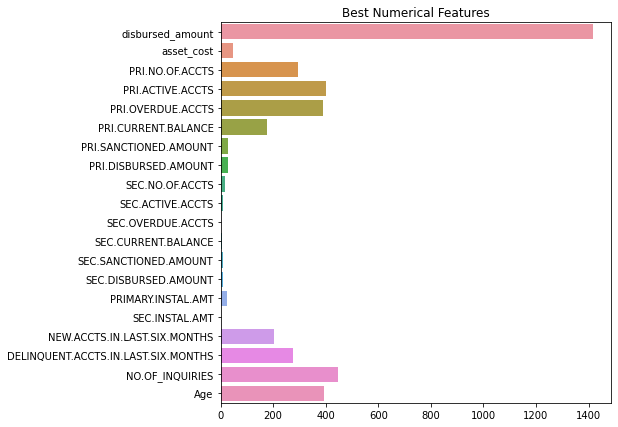

In [24]:
# 特征选择
from sklearn.feature_selection import SelectKBest, f_classif

n = SelectKBest(score_func=f_classif, k=10)
numcols = n.fit(df[numerical], df['loan_default'])
plt.figure(figsize=(7, 7))
sns.barplot(x=numcols.scores_, y=numerical)
plt.title('Best Numerical Features')
plt.show()

该图显示二级帐户信息微不足道。当然，银行也不能放弃二级账户信息，因此我们必须将初级账户和次级账户信息结合起来。



In [20]:
df.loc[:, 'No of Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df.loc[:, 'PRI Inactive accounts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:, 'SEC Inactive accounts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:, 'Total Inactive accounts'] = df['PRI Inactive accounts'] + df['SEC Inactive accounts']
df.loc[:, 'Total Overdue Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:, 'Total Current Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:, 'Total Sanctioned Amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:, 'Total Disbursed Amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:, 'Total Installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

### 分类特征变量的卡方检验



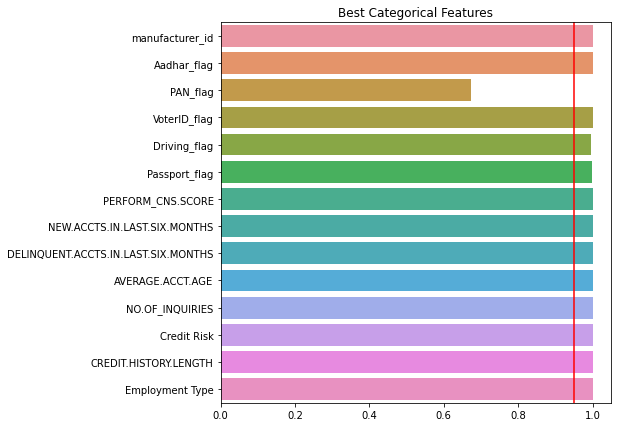

In [21]:
# 分类特征变量的卡方检验
from scipy.stats import chi2_contingency

l = []
for i in categorical:
    pvalue = chi2_contingency(pd.crosstab(df['loan_default'], df[i]))[1]
    l.append(1 - pvalue)
plt.figure(figsize=(7, 7))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1 - 0.05), color='r')
plt.show()

在这里，图表也显示了对替代假设的接受。同样，我们可以观察到credit score和PAN Card之间的一些多重共线性，因为PAN Card是获得信用评分的必修课。因此，卡方检验认为它认为它对我们的研究有盈余。但为了争论，我们会保留它。



In [22]:
df = df.drop(
    ['PRI.NO.OF.ACCTS', 'SEC.NO.OF.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI Inactive accounts', 'SEC Inactive accounts',
     'PRI.SANCTIONED.AMOUNT', 'SEC.NO.OF.ACCTS', 'PRI.NO.OF.ACCTS', 'PRI.DISBURSED.AMOUNT', 'PRI.ACTIVE.ACCTS',
     'PRI.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
     'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'disbursed_amount', 'SEC.ACTIVE.ACCTS'], axis=1)

nums = ['asset_cost', 'ltv', 'PERFORM_CNS.SCORE',
        'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
        'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'No of Accounts', 'Total Inactive accounts',
        'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
        'Total Disbursed Amount', 'Total Installment', 'Age']


## 5.特征工程


### 建立特征数据和标签数据

loan_default为标签数据，除 loan_default之外的为特征数据。关键代码如下：



In [23]:
# 建立特征数据和标签数据
y = df.loan_default
X = df.drop("loan_default", axis=1)

### 数据集拆分
训练集拆分，分为训练集和验证集，70%训练集和30%验证集。关键代码如下：



In [24]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
# 数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## 6.构建逻辑回归和xgboost分类模型
主要使用使用LogisticRegression、XGBClassifier算法，用于目标分类。

### 建立逻辑回归模型



In [28]:
# 建立逻辑回归模型
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# 模型评估
print('train accuracy :', lr.score(X_train, y_train))
print('test accuracy :', lr.score(X_test, y_test))
print("precision :", precision_score(y_test, y_pred), "\n")
print("recall :", recall_score(y_test, y_pred), "\n")
print("f1 score:", f1_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))


train accuracy : 0.7829443590042093
test accuracy : 0.7827783893519379
precision : 0.0 

recall : 0.0 

f1 score: 0.0 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54756
           1       0.00      0.00      0.00     15191

    accuracy                           0.78     69947
   macro avg       0.39      0.50      0.44     69947
weighted avg       0.61      0.78      0.69     69947



首先通过建立逻辑回归模型看到查准率、查全率、F1分值都是0，说明这是一个无效的模型；可能的原因目标变量分布不均衡,接下来咱们查看一下标签变量的分布：



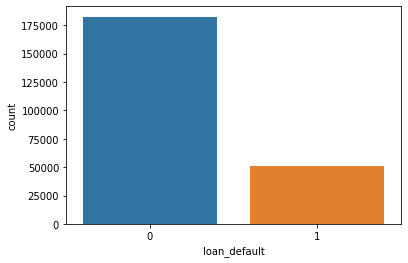

In [27]:
# 标签变量的分布分析
sns.countplot(df['loan_default'])
plt.show()

通过上图可以清晰地看到，标签变量的数据分布确实不均衡。

那么接下来在查看一下信用历史特征的分布情况：所包含的特征：



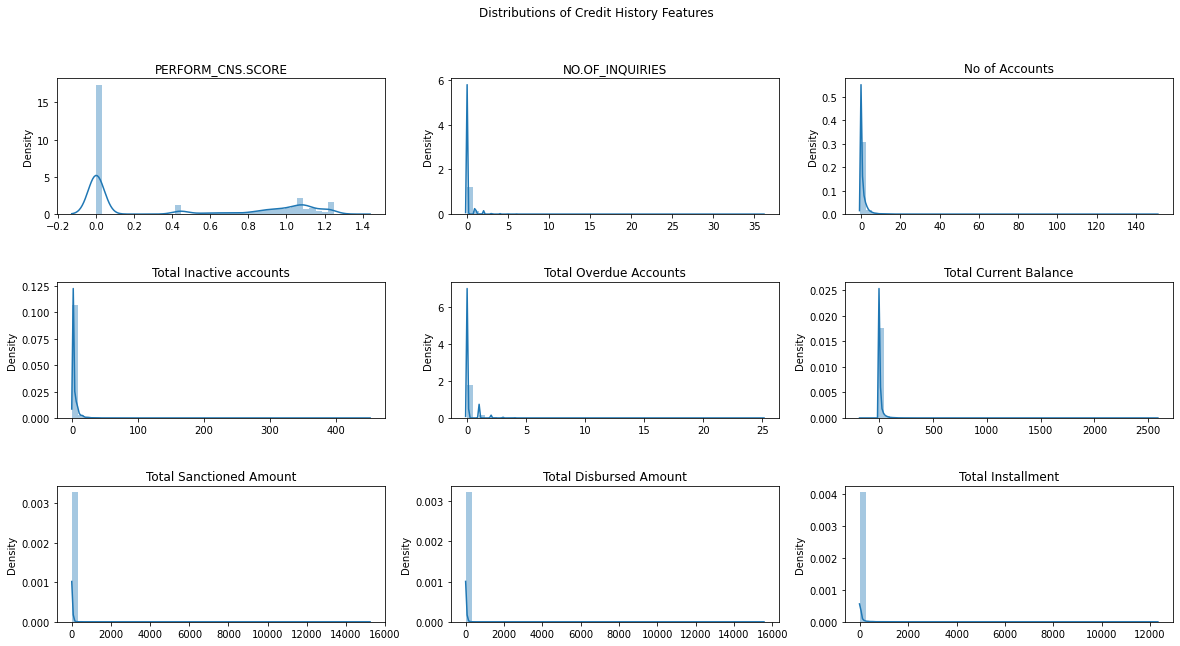

In [29]:
# 查看一下信用历史特征的分布情况
n = ['PERFORM_CNS.SCORE', 'NO.OF_INQUIRIES', 'No of Accounts', 'Total Inactive accounts',
     'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
     'Total Disbursed Amount', 'Total Installment']
data = df[n]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Credit History Features')

for ax, feature, name in zip(axes.flatten(), data.values.T, data.columns):
    sns.distplot(feature, ax=ax)
    ax.set(title=str(name))
plt.show()



首次申请贷款的客户数量最多，这解释了为什么上述所有列都有如此多的零值。此外，还有许多值得注意的离群值。



### 离群值处理

让我们处理离群值。我们将尝试保留离群值记录，而不是删除它们。我们将使用RobustScaler使观测值更接近中值。

RobustScaler原理与StandardScaler类似，使每一个特征的统计属性都位于同一范围。RobustScalar与StandardScaler不同的是，RobustScaler使用的是中位数和四分位数。

RobustScaler会忽略异常值（即与其他多数点有非常大差异的点）。

- https://zhuanlan.zhihu.com/p/201192976

关键代码： 

In [30]:
from sklearn.preprocessing import RobustScaler
# 离群值处理
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])

现在，对于零观测，我们将制作一个新功能，计算零的功能。这将作为有信用记录的人和没有信用记录的人之间的标准。当然，没有信用记录的人可能会有超过9个特征为零，在客户有信用记录的情况下这种情况是不太可能的。

关键代码：



In [31]:
df['Missing Features'] = (df == 0).astype(int).sum(axis=1)

### 模型调优

本项目主要是对XGBClassifier分类算法使用GridSearchCV (网格搜索)进行参数的调优，找出模型模型最优的参数，然后进行建模。



In [34]:
from sklearn.model_selection import GridSearchCV
# 模型参数调优
param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test1, scoring='roc_auc', n_jobs=4, cv=3)
gsearch1.fit(X_train, y_train)

print('param_test1的调优结果如下：')
print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

param_test1的调优结果如下：
{'mean_fit_time': array([ 38.67510947,  37.80587141,  37.91715614,  62.05941447,
        61.72285175,  61.38035989,  90.44046442,  88.34720707,
        87.19070148, 122.24484619, 118.53486482,  93.87551506]), 'std_fit_time': array([ 0.17346261,  0.51542145,  0.327513  ,  0.3865283 ,  0.2063836 ,
        0.39907718,  0.82108579,  0.37330919,  0.24349663,  0.65622271,
        0.35484347, 16.97028434]), 'mean_score_time': array([0.62528634, 0.78097415, 0.6770366 , 0.91640337, 1.03135077,
       0.95093838, 1.37745253, 1.34393334, 1.3514959 , 1.66395505,
       1.62561162, 0.76595791]), 'std_score_time': array([0.15991555, 0.16950944, 0.05981827, 0.12447952, 0.03118649,
       0.1881253 , 0.03440886, 0.04398037, 0.09936991, 0.20491138,
       0.13685639, 0.29790978]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       

### 模型参数 



In [35]:
# 建立调优后的模型
xgb4 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=9,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.005,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

xgb4.fit(X_train, y_train)  # 拟合
y_pred = xgb4.predict(X_test)  # 预测
# 模型评估
print("accuracy train:", xgb4.score(X_train, y_train), "\n")
print("accuracy test:", xgb4.score(X_test, y_test), "\n")
print("precision :", precision_score(y_test, y_pred), "\n")
print("Recall :", recall_score(y_test, y_pred), "\n")
print("f1 score:", f1_score(y_test, y_pred), "\n")

accuracy train: 0.8386956441819284 

accuracy test: 0.7818348177906129 

precision : 0.46229508196721314 

Recall : 0.027845434796919227 

f1 score: 0.05252700856823544 

Confusion Matrix 
 [[54264   492]
 [14768   423]]


### 混淆矩阵

xgboost分类模型混淆矩阵：

In [36]:
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))

Confusion Matrix 
 [[54264   492]
 [14768   423]]


### ROC曲线

这里效果不好是因为参数调优只用了一轮，为了演示方便，具体的完整效果可以看最后的图。

[0.         0.         0.         ... 0.99972606 0.99972606 1.        ] [0.00000000e+00 6.58284511e-05 3.29142255e-04 ... 9.99868343e-01
 1.00000000e+00 1.00000000e+00]


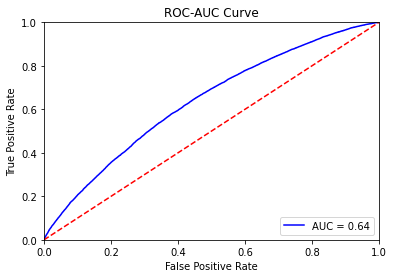

In [39]:
import sklearn.metrics as metrics

# ROC 曲线绘制
probs = xgb4.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
print(fpr, tpr)

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()


### 模型特征重要性 
从上图可以看到特征变量对此模型的重要性依次为：PAN_flag、No of Accounts、Missing Features等等。

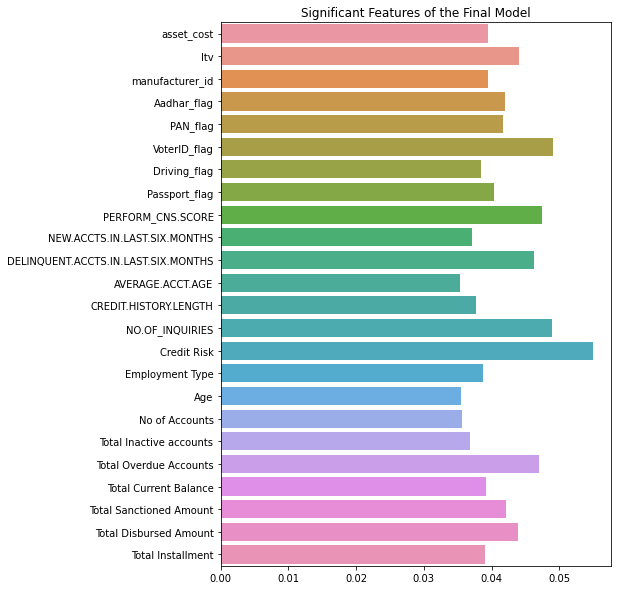

In [38]:
# 绘制模型特征重要性图
plt.figure(figsize=(7, 10))
sns.barplot(x=xgb4.feature_importances_, y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()

## 完整代码

0   -1
1    5
2   -1
3    2
4   -1
Name: Credit Risk, dtype: int64
0    1
1    0
2    0
3    0
4    0
Name: Employment Type, dtype: int64
0    19
1    41
2    16
3    33
4    49
Name: Age, dtype: int64


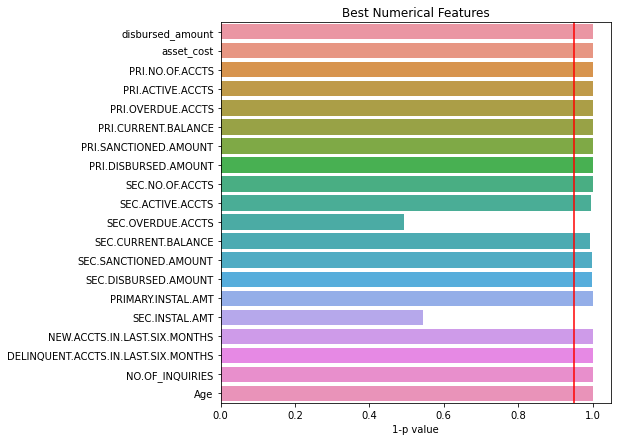

13140.699007454981 12150.255527172329
19015.002867400774 18680.502608619492
5.261141650236005 5.04013362644165
2.0082420121201543 1.6699657272094286
0.5320262425886055 0.6034839757822386
994631.7352945457 720451.2837834031
1234346.7457205276 4525738.059420681
1240214.826412385 4527095.229863031
0.6516570890275873 0.527358347626265
0.32337474128357524 0.2880958812264165
0.1112491367023999 0.11046343401346002
184110.75765814638 106044.4250689912
195212.28973392927 130717.86808523617
194597.53945599656 130392.76612443924
157963.98513600946 124665.51133351553
16588.052553508056 11045.628444420758
0.9729689997390004 0.8856611487937556
0.37023513218495563 0.43087164170425074
0.6655358308421763 0.8351467924444976
31.086834643098857 33.43650051533342
0.9729689997390004 0.8856611487937556
0.37023513218495563 0.43087164170425074


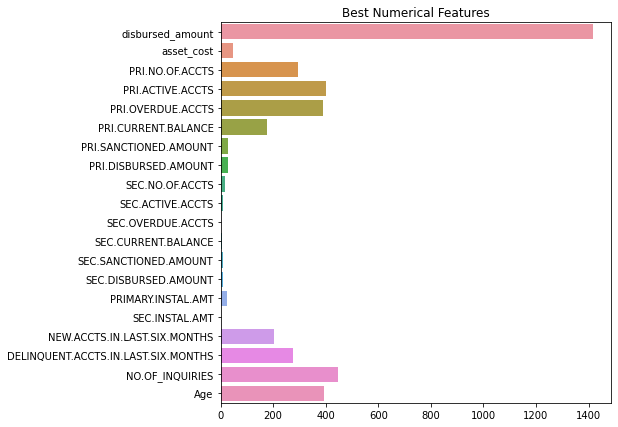

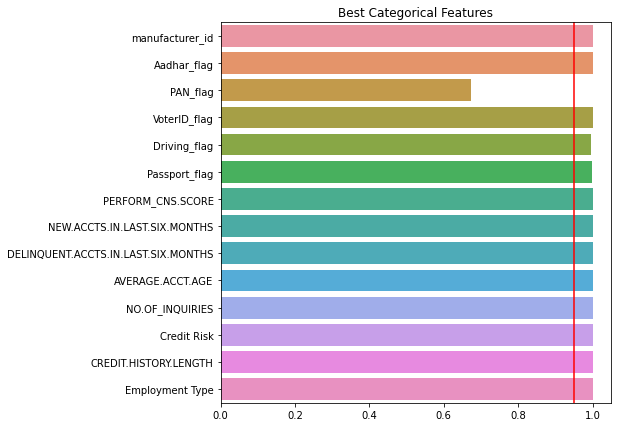

0     0
1    23
2     0
3     8
4     0
Name: AVERAGE.ACCT.AGE, dtype: int64
0     0
1    23
2     0
3    15
4     0
Name: CREDIT.HISTORY.LENGTH, dtype: int64
16
train accuracy : 0.7829443590042093
test accuracy : 0.7827783893519379
precision : 0.0 

recall : 0.0 

f1 score: 0.0 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54756
           1       0.00      0.00      0.00     15191

    accuracy                           0.78     69947
   macro avg       0.39      0.50      0.44     69947
weighted avg       0.61      0.78      0.69     69947



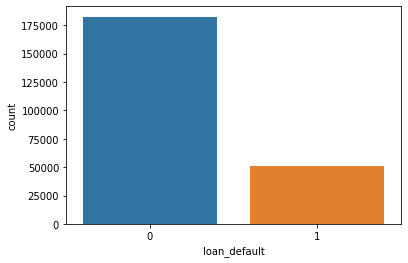

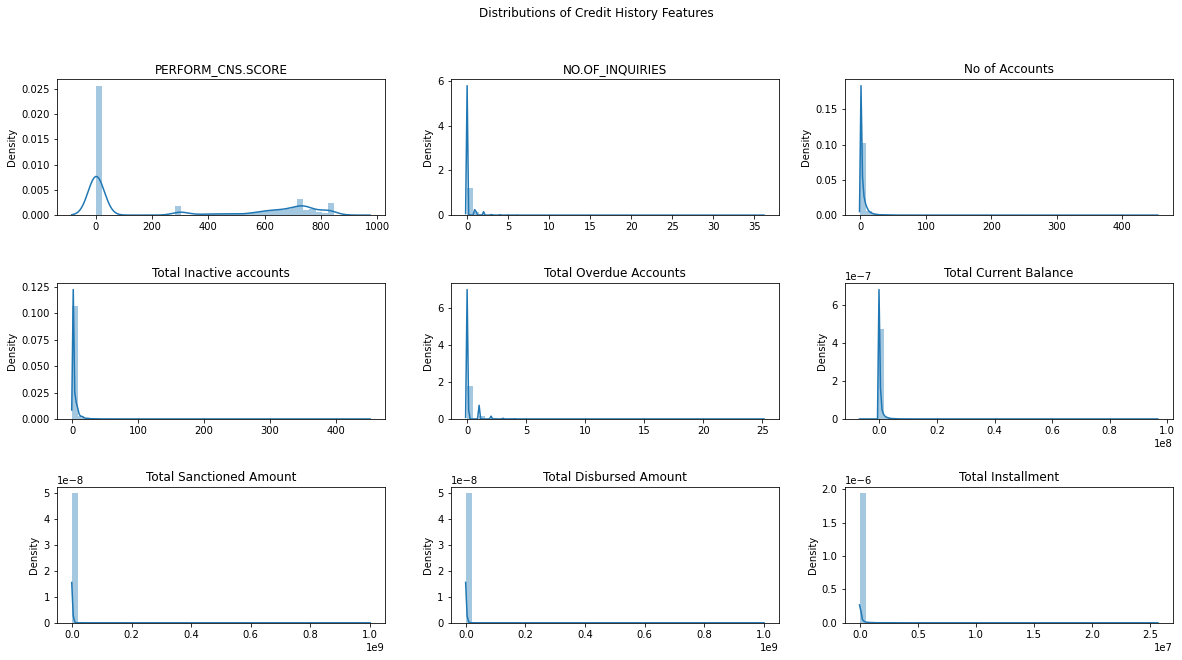

param_test1的调优结果如下：
{'mean_fit_time': array([ 39.82313013,  39.63711754,  39.84015171,  66.00977778,
        65.74294964,  65.69182269, 100.88936202,  98.36581413,
        97.35862875, 140.50949327, 136.98964143, 108.10326306]), 'std_fit_time': array([ 0.38571335,  0.45330791,  0.08206091,  0.38375592,  0.7425443 ,
        0.57013553,  0.6192702 ,  0.39709009,  0.54721722,  0.07325347,
        1.18144307, 20.93095089]), 'mean_score_time': array([0.7758046 , 0.74069166, 0.67520968, 1.0168767 , 1.16172727,
       1.07126164, 1.26099706, 1.29918551, 1.45126406, 1.68220456,
       1.71565692, 0.7770946 ]), 'std_score_time': array([0.16338141, 0.038955  , 0.01496767, 0.08829122, 0.02560205,
       0.06832463, 0.11547958, 0.13243142, 0.04186066, 0.14502688,
       0.10017637, 0.30720885]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       

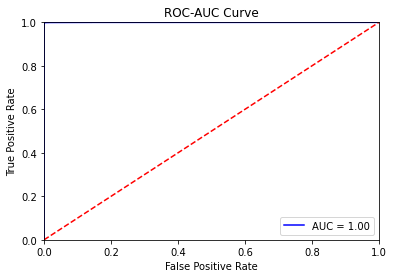

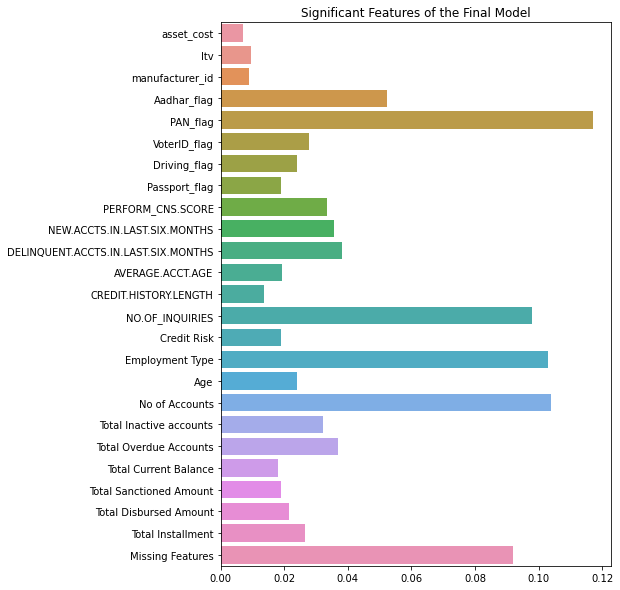

In [40]:
#!/usr/bin/env python
# coding: utf-8

# 导入各种工具
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
# 集成方法
from xgboost import XGBClassifier
# 评估指标
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, \
    classification_report, confusion_matrix

# warnings包
import warnings

warnings.filterwarnings("ignore")

df = pd.read_excel('data.xlsx')
# 去除挖掘无关重要的特征
df = df.drop(
    ['UniqueID', 'branch_id', 'supplier_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],
    axis=1)


# 特征文本数据转换
def credit_risk(df):
    d1 = []
    d2 = []
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d2


sub_risk = {'unknown': -1, 'A': 13, 'B': 12, 'C': 11, 'D': 10, 'E': 9, 'F': 8, 'G': 7, 'H': 6, 'I': 5, 'J': 4, 'K': 3,
            'L': 2, 'M': 1}
employment_map = {'Self employed': 0, 'Salaried': 1, np.nan: 2}

df.loc[:, 'credit_risk_grade'] = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:, 'Credit Risk'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

print(df['Credit Risk'].head())

df.loc[:, 'Employment Type'] = df['Employment.Type'].apply(lambda x: employment_map[x])

print(df['Employment Type'].head())

df = df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade', 'Employment.Type'], axis=1)

# 客户年龄计算
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >= 0 and yr <= 19:
        return yr + 2000
    else:
        return yr + 1900


def age1(dur):
    yr = int(dur.split('/')[0])

    return yr


df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age1)
df['Age'] = df['DisbursalDate'] - df['Date.of.Birth']
df = df.drop(['DisbursalDate', 'Date.of.Birth'], axis=1)

print(df['Age'].head())

numerical = ['disbursed_amount', 'asset_cost', 'PRI.NO.OF.ACCTS',
             'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
             'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
             'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
             'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
             'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
             'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'Age', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
             'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
categorical = ['manufacturer_id', 'Aadhar_flag', 'PAN_flag',
               'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
               'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
               'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES', 'Credit Risk', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH',
               'Employment Type']

# 数值型特征变量T检验与特征选择
p = []
from scipy.stats import ttest_ind

for i in numerical:
    df1 = df.groupby('loan_default').get_group(0)
    df2 = df.groupby('loan_default').get_group(1)
    t, pvalue = ttest_ind(df1[i], df2[i])
    p.append(1 - pvalue)
plt.figure(figsize=(7, 7))
sns.barplot(x=p, y=numerical)
plt.title('Best Numerical Features')
plt.axvline(x=(1 - 0.05), color='r')
plt.xlabel('1-p value')
plt.show()

for i in numerical:
    df1 = df.groupby('loan_default').get_group(0)
    df2 = df.groupby('loan_default').get_group(1)
    print(np.std(df1[i], ddof=1), np.std(df2[i], ddof=1))

# 特征选择
from sklearn.feature_selection import SelectKBest, f_classif

n = SelectKBest(score_func=f_classif, k=10)
numcols = n.fit(df[numerical], df['loan_default'])
plt.figure(figsize=(7, 7))
sns.barplot(x=numcols.scores_, y=numerical)
plt.title('Best Numerical Features')
plt.show()

df.loc[:, 'No of Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df.loc[:, 'PRI Inactive accounts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:, 'SEC Inactive accounts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:, 'Total Inactive accounts'] = df['PRI Inactive accounts'] + df['SEC Inactive accounts']
df.loc[:, 'Total Overdue Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:, 'Total Current Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:, 'Total Sanctioned Amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:, 'Total Disbursed Amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:, 'Total Installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

# 分类特征变量的卡方检验
from scipy.stats import chi2_contingency

l = []
for i in categorical:
    pvalue = chi2_contingency(pd.crosstab(df['loan_default'], df[i]))[1]
    l.append(1 - pvalue)
plt.figure(figsize=(7, 7))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1 - 0.05), color='r')
plt.show()

# 文本数据处理
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs', ''))
    mon = int(dur.split(' ')[1].replace('mon', ''))
    return yrs * 12 + mon


df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)

print(df['AVERAGE.ACCT.AGE'].head())
print(df['CREDIT.HISTORY.LENGTH'].head())

df = df.drop(
    ['PRI.NO.OF.ACCTS', 'SEC.NO.OF.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI Inactive accounts', 'SEC Inactive accounts',
     'PRI.SANCTIONED.AMOUNT', 'SEC.NO.OF.ACCTS', 'PRI.NO.OF.ACCTS', 'PRI.DISBURSED.AMOUNT', 'PRI.ACTIVE.ACCTS',
     'PRI.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
     'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'disbursed_amount', 'SEC.ACTIVE.ACCTS'], axis=1)

nums = ['asset_cost', 'ltv', 'PERFORM_CNS.SCORE',
        'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
        'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'No of Accounts', 'Total Inactive accounts',
        'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
        'Total Disbursed Amount', 'Total Installment', 'Age']

print(len(nums))

# 建立特征数据和标签数据
y = df.loan_default
X = df.drop("loan_default", axis=1)

from sklearn.model_selection import train_test_split, KFold, cross_val_score
# 数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# 建立逻辑回归模型
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# 模型评估
print('train accuracy :', lr.score(X_train, y_train))
print('test accuracy :', lr.score(X_test, y_test))
print("precision :", precision_score(y_test, y_pred), "\n")
print("recall :", recall_score(y_test, y_pred), "\n")
print("f1 score:", f1_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

# 标签变量的分布分析
sns.countplot(df['loan_default'])
plt.show()

# 查看一下信用历史特征的分布情况
n = ['PERFORM_CNS.SCORE', 'NO.OF_INQUIRIES', 'No of Accounts', 'Total Inactive accounts',
     'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
     'Total Disbursed Amount', 'Total Installment']
data = df[n]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Credit History Features')

for ax, feature, name in zip(axes.flatten(), data.values.T, data.columns):
    sns.distplot(feature, ax=ax)
    ax.set(title=str(name))
plt.show()

from sklearn.preprocessing import RobustScaler
# 离群值处理
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])

df['Missing Features'] = (df == 0).astype(int).sum(axis=1)

# 建立特征数据和标签数据
y = df.loan_default
X = df.drop("loan_default", axis=1)

from sklearn.model_selection import train_test_split, KFold, cross_val_score
# 数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

from sklearn.model_selection import GridSearchCV

# 模型参数调优
param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test1, scoring='roc_auc', n_jobs=4, cv=3)
gsearch1.fit(X_train, y_train)

print('param_test1的调优结果如下：')
print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

param_test2b = {
    'max_depth': range(7, 10, 2)
}
gsearch2b = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=4,
                                                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                         param_grid=param_test2b, scoring='roc_auc', n_jobs=4, cv=3)
gsearch2b.fit(X_train, y_train)

print('gsearch2b的调优结果如下：')
print(gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_)

param_test3 = {
    'gamma': [i / 10.0 for i in range(0, 5)]
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=9,
                                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test3, scoring='roc_auc', n_jobs=4, cv=5)
gsearch3.fit(X_train, y_train)
print('gsearch3的调优结果如下：')
print(gsearch3.best_params_, gsearch3.best_score_)

# 建立调优后的模型
xgb4 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=9,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.005,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

xgb4.fit(X_train, y_train)  # 拟合
y_pred = xgb4.predict(X_test)  # 预测
# 模型评估
print("accuracy train:", xgb4.score(X_train, y_train), "\n")
print("accuracy test:", xgb4.score(X_test, y_test), "\n")
print("precision :", precision_score(y_test, y_pred), "\n")
print("Recall :", recall_score(y_test, y_pred), "\n")
print("f1 score:", f1_score(y_test, y_pred), "\n")
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))

import sklearn.metrics as metrics

# ROC 曲线绘制
probs = xgb4.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
print(fpr, tpr)

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()

# 绘制模型特征重要性图
plt.figure(figsize=(7, 10))
sns.barplot(x=xgb4.feature_importances_, y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()
